# Problem Statement: https://www.kaggle.com/competitions/jargon-detection/overview
###    Technical terminology expressions are unique to a particular field and have implied meanings that do not conform to common expectations. Non-experienced individuals would either be completely unaware of the meaning of such concepts or tend to interpret common words in a different sense than intended, failing to understand the communication attempt in either case. This, in turn, creates a significant entry barrier to reading scholarly writing. A primordial first step to creating a scientific-document reading system is to be able to recognize these technical terms that could delay, or even impede, reader understanding. As very few research efforts have been devoted to this matter, we propose a technical terminology detection shared task at SDU@AAAI-23 in an attempt to push forward the research on technical terminology understanding.

### Task 1 - Jargon/Terminology Detection
#### This task aims to identify domain-specific technical terminology, a.k.a. jargon, used in scientific research papers. This includes both words that are specific to a field or commonly used terms that acquire particular meanings within such a field. For instance:

#### Input: Afterwards, model training is performed using cross-entropy loss.

#### Output: Afterwards, model training is performed using cross-entropy loss.

#### In this example, the terms "model training" and "cross-entropy loss" are technical computer science concepts that should be identified. To simplify the task, only the main noun in a nominal phrase should be tagged. The task is modeled as a sentence-level sequence labeling problem. Participants are provided with manually-labeled training and development datasets from three distinct scientific domains: Computer Science, Economics, and Physics. Each scientific domain has its own train/dev/test splits. Considering both the training and development sets, the provided dataset includes 7000+ Computer Science sentences, 6000+ Economics sentences, and 8000+ Physics sentences. The submitted systems will be evaluated based on their precision, recall, and F1 scores on the hidden test set computed for correct prediction boundaries in the sentences.

# Acquire Data

## Import libraries numpy, pandas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Jargon/validation.csv
/kaggle/input/Jargon/test_no_labels.csv
/kaggle/input/Jargon/train.csv


## Load appropriate version of Keras and TensorFlow compatible with pre-trained ELMo embedding

In [2]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0


Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.6/339.6 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=57d2c938bffc7a9aa1f27c22fc4eef1aef27dad6945d321373820ae7cc653650
  Stored in directory: /root/.cache/pip/w

## Save environment with package version details

In [3]:
import subprocess

# Run the conda list command and capture the output
result = subprocess.run(['conda', 'list'], capture_output=True, text=True)

# Save the output to a text file
with open('conda_list_jargonDetection.txt', 'w') as file:
    file.write(result.stdout)

print('conda list output has been saved to conda_list.txt')


conda list output has been saved to conda_list.txt


## Define batch_size and import tensorflow and tensorflow hub to load elmo embedding model

In [4]:
batch_size = 32
import tensorflow as tf
print(f"tf ver: {tf.__version__}")
import tensorflow_hub as hub

tf ver: 1.15.0


## import keras compatible version

In [5]:
import keras
print(f"keras ver: {keras.__version__}")

keras ver: 2.1.6


Using TensorFlow backend.


## import matplotlib and load full-train data

In [6]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

data = pd.read_csv("/kaggle/input/Jargon/train.csv")
data = data.fillna(method="ffill")
data.tail(12)

,token_id,token,label
574898,phys/doc_1866/5/13,relaxation,O
574899,phys/doc_1866/5/14,data,TERM
574900,phys/doc_1866/5/15,for,O
574901,phys/doc_1866/5/16,voltage,TERM
574902,phys/doc_1866/5/17,and,O
574903,phys/doc_1866/5/18,charge,TERM
574904,phys/doc_1866/5/19,obtained,O
574905,phys/doc_1866/5/20,from,O
574906,phys/doc_1866/5/21,a,O
574907,phys/doc_1866/5/22,commercial,O


# check output class balance

In [8]:
data['label'].value_counts()

O       520286
TERM     54624
Name: label, dtype: int64

### We are not removing class imbalance because it affects token prediction preformance results in validation and test sets

## Set up corpus vocabulary and add 'PADword' as a valid token in dictionary for padding

In [9]:
words = set(list(data['token'].values))
words.add('PADword')
n_words = len(words)
n_words

29483

## set output tags 

In [10]:
tags = list(set(data["label"].values))
n_tags = len(tags)
n_tags

2

## Create unique id to extract sentences based on their token_id

### Create intermediate prefix column from token_id

In [11]:
data['prefix'] = data['token_id'].apply(lambda x: x.split('/')[:3])
data['prefix'] = data['prefix'].apply(lambda x: '/'.join(x))

### Create id column which is unique sentence-wise and not word wise

In [12]:

id_dict = {}
id_counter = 0
for token_id in data['prefix']:
    if token_id not in id_dict:
        id_dict[token_id] = id_counter
        id_counter += 1

# Replace the token IDs in the data with their corresponding integer IDs
data["id"] = [id_dict[token_id] for token_id in data["prefix"]]

### Unique id column is already present so drop other unused columns

In [13]:
data = data.drop(['token_id', 'prefix'], axis=1)

### Check input pre-processed dataframe

In [14]:
data

,token,label,id
0,A,O,0
1,SHAP,O,0
2,summary,O,0
3,plot,TERM,0
4,shows,O,0
...,...,...,...
574905,from,O,21017
574906,a,O,21017
574907,commercial,O,21017
574908,supercapacitor,TERM,21017


## Create sentence getter class which returns list of sentences grouping by id

In [15]:
class SentenceGetter(object):    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("id").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

## Visualize a sentence and check out how each word in a sentence is zipped along with their label

In [16]:
getter = SentenceGetter(data)

### Sentence getter paired with labels

In [17]:
sent = getter.get_next()
print(sent)

[('Figure', 'O'), ('~', 'O'), ('shows', 'O'), ('two', 'O'), ('examples', 'O'), ('of', 'O'), ('SHAP', 'TERM'), ('summary', 'O'), ('plots', 'O'), ('.', 'O')]


### Find length of biggest sentence

In [18]:
sentences = getter.sentences
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 344 words


## Plot sentence length distribution

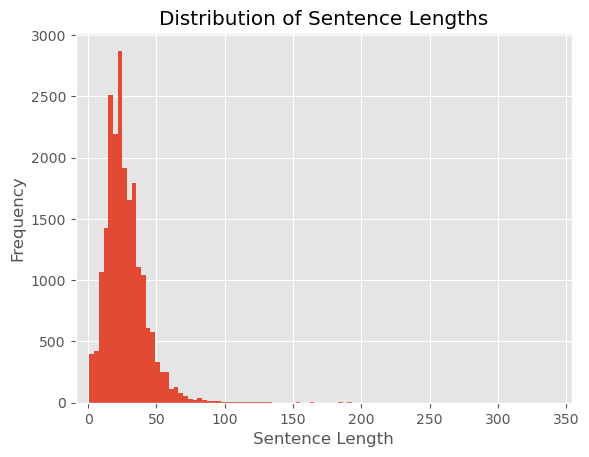

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

sent_lengths = [len(sen) for sen in sentences]
max_len = max(sent_lengths)
min_len = min(sent_lengths)
freq = sent_lengths.count(max_len)

plt.hist(sent_lengths, bins=100)
plt.xlim([min_len-10, max_len+10])
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.savefig('DistSentLen.png')  # Save plot as PNG file
plt.show()

## Create word to index and tag to index dictionaries

In [20]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}

tags2index['TERM'] = 1
tags2index['O'] = 0
print(tags2index['TERM'])

1


## Create a list of sentences and prepare X_train, y_train
### Steps are as follows:
#### 1. Set a maximum length for the sequences as 25, 
#### 2. Extract the words and their corresponding tags from the input sentences. 
#### 3. Create new sequences that are either shorter or equal to the maximum length by either breaking down the sentence into smaller sentences or padding the original sentence with "PADword" to make it the same length as the maximum length. 
#### 4. The resulting X_train and y_train variables contain the padded or broken-down sentences and their corresponding labels, respectively. 
#### 5. The padwordCount_sentwise variable stores the number of "PADword" paddings added to each sentence, which we use later in the code.

In [21]:
max_len = 25
X = [[w[0] for w in s] for s in sentences]
y = [[tags2index[w[1]] for w in s] for s in sentences]
X_train = []
y_train = []
padwordCount_sentwise = []
for seq_x, seq_y in zip(X, y):
    if len(seq_x) > max_len:
        # Break sentence into temporary list of sentences of size 25 or less
        temp_seq_x = []
        temp_seq_y = []
        while len(seq_x) > max_len:
            temp_seq_x.append(seq_x[:max_len])
            temp_seq_y.append(seq_y[:max_len])
            seq_x = seq_x[max_len:]
            seq_y = seq_y[max_len:]
        temp_seq_x.append(seq_x)
        temp_seq_y.append(seq_y)

        # Create an entry in new_X and new_y for each sentence and add corresponding padwords count
        for temp_x, temp_y in zip(temp_seq_x, temp_seq_y):
            new_seq_x = temp_x + ["PADword"] * (max_len - len(temp_x))
            new_seq_y = temp_y + [0] * (max_len - len(temp_y))
            X_train.append(new_seq_x)
            y_train.append(new_seq_y)
            padwordCount_sentwise.append(len([word for word in new_seq_x if word == "PADword"]))

    elif len(seq_x) < max_len:
        # Pad sentence with 'PADword' to make it max_len in length
        new_seq_x = seq_x + ["PADword"] * (max_len - len(seq_x))
        new_seq_y = seq_y + [0] * (max_len - len(seq_y))
        X_train.append(new_seq_x)
        y_train.append(new_seq_y)
        padwordCount_sentwise.append(len([word for word in new_seq_x if word == "PADword"]))

    else:
        # Sentence length is already max_len, just add to new_X and new_y, and padwords count as 0
        X_train.append(seq_x)
        y_train.append(seq_y)
        padwordCount_sentwise.append(0)


## Post data wrangling we got the below # sentences 

In [22]:
print(f"X shape : {len(X_train)}")
print(f"y shape : {len(y_train)}")

X shape : 32777
y shape : 32777


In [23]:
X_train[0]

['A',
 'SHAP',
 'summary',
 'plot',
 'shows',
 'the',
 'SHAP',
 'value',
 'of',
 'features',
 'for',
 'individual',
 'data',
 'points',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

## Transform y_train to one-hot encoding for calculating loss 

In [24]:
from keras.utils import to_categorical

# Apply one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=2)

In [25]:
y_train_one_hot[0]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [26]:
y_train[0]

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Print X-train and y-train shape and len

In [27]:
print(f"y_train: {len(y_train)}, {len(y_train[0])}")
print(f"X_train: {len(X_train)}, {len(X_train[0])}")
print(f"y_train: {type(y_train)}")
print(f"X_train: {type(X_train)}")

y_train: 32777, 25
X_train: 32777, 25
y_train: <class 'list'>
X_train: <class 'list'>


## import keras backend libraries
### Load the pre-trained ELMo model from TensorFlow Hub using the hub.Module() function. The trainable parameter is set to True, which allows fine-tuning of the pre-trained model during training.

In [28]:
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

2023-04-30 13:04:51.619414: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)


## Define Elmo Embedding layer

In [29]:
def ElmoEmbedding(tokens_input):
    return elmo_model(inputs={"tokens": tf.squeeze(tf.cast(tokens_input,tf.string)),"sequence_len": tf.constant(batch_size*[max_len])},signature="tokens",as_dict=True)["elmo"]


## install keras-contrib for crf layer

In [30]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-su_qkk_y
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-su_qkk_y
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=3ba4a50c7b3ab83ce666617c92d378fde57b31c1df757b33ebb1ac5369052fef
  Stored in directory: /tmp/pip-ephem-wheel-cache-7idiehtg/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


## importing required Keras modules

In [31]:
from keras.models import Model, Input # for defining a Keras model and its input
from keras.layers.merge import add # for merging layers
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda # for defining different layers in a Keras model
from keras_contrib.layers import CRF # for using the CRF layer from Keras_contrib library

## Define elmo + bi-lstm + crf model
### Steps:
#### 1. The input layer is defined with the shape of (max_len,), which is the maximum length of the input sequence.

#### 2. The ElmoEmbedding layer is defined using the Lambda function from Keras, which takes the input layer as input and returns the ELMo embeddings of the input sequence as output.

#### 3. Two Bidirectional LSTM layers are added, each with 512 units, and both are connected to the ElmoEmbedding layer. Both LSTM layers have dropout and recurrent dropout set to 0.2.

#### 4. A residual connection is added from the first LSTM layer to the second LSTM layer using the add function from Keras.

#### 5. A TimeDistributed dense layer is added to the network to compute the probability distribution over each label for each token in the input sequence.

#### 6. A CRF layer is added on top of the TimeDistributed dense layer, which learns the transition probabilities between labels and returns the most probable sequence of labels for the input sequence.

##### Note: In the context of 'CRF(2, sparse_target=False, name='crf')' sparse_target=False means that the target values for each sequence in the batch are not expected to be in a sparse format, but instead a dense format where each value is explicitly represented. 

In [32]:
input_layer = Input(shape=(max_len,), 
                    dtype=tf.string, 
                    name='input_layer')

elmo_embeddings = Lambda(ElmoEmbedding, 
                   output_shape=(max_len, 1024),
                   name='elmo_embeddings')(input_layer)

lstm_1 = Bidirectional(LSTM(units=512, 
                             return_sequences=True, 
                             recurrent_dropout=0.2, 
                             dropout=0.2, 
                             name='lstm1'),name='Bi-LSTM1')(elmo_embeddings)

lstm_2 = Bidirectional(LSTM(units=512, 
                            return_sequences=True,
                            recurrent_dropout=0.2, 
                            dropout=0.2,
                            name='lstm2'),name='Bi-LSTM2')(lstm_1)

lstm = add([lstm_1, lstm_2], name='add_LSTMs')  # residual connection to the first biLSTM

TimeDistributedDense = TimeDistributed(Dense(2, 
                               activation='sigmoid', 
                               name='dense'), name='TD-Dense')(lstm)

crf = CRF(2, sparse_target=False, name='crf')

# Add the CRF layer to the model
output = crf(TimeDistributedDense)

tech_jargon_model = Model(inputs=input_layer, 
                          outputs=output)

## print model summary

In [33]:
#Print the summary
tech_jargon_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 25)           0                                            
__________________________________________________________________________________________________
elmo_embeddings (Lambda)        (None, 25, 1024)     0           input_layer[0][0]                
__________________________________________________________________________________________________
Bi-LSTM1 (Bidirectional)        (None, 25, 1024)     6295552     elmo_embeddings[0][0]            
__________________________________________________________________________________________________
Bi-LSTM2 (Bidirectional)        (None, 25, 1024)     6295552     Bi-LSTM1[0][0]                   
__________________________________________________________________________________________________
add_LSTMs 

## plot and save the model architecture

In [34]:
from keras.utils import plot_model

In [35]:
plot_model(tech_jargon_model, show_shapes=True, show_layer_names=True, to_file='jargonDetectionModelSummary.png')

## add padding to match batch size of last batch

In [36]:
# Define the number of sentences to generate
num_sentences = batch_size-(len(X_train)%batch_size)
print(f"Extra sentences needed to pad: {num_sentences}")
# Define the length of each sentence
sentence_length = 25

# Generate the sentences
sentences = [['PADword' for _ in range(sentence_length)] for _ in range(num_sentences)]

# Add the sentences to X_tr
X_train.extend(sentences)
# Add the rows to y_tr
# Create an array of zeros with shape (num_rows, 25, 2)
zeros = np.zeros((num_sentences, 25, 2))

# Concatenate the zeros array with y_tr along the first axis
y_train_one_hot = np.concatenate((y_train_one_hot, zeros), axis=0)

# Print the shapes of X_tr and y_tr
print(f"X_train shape: {len(X_train)}")
print(f"y_train shape: {y_train_one_hot.shape}")

Extra sentences needed to pad: 23
X_train shape: 32800
y_train shape: (32800, 25, 2)


## Define and compile model configurations

In [37]:
from keras.optimizers import Adam
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

tech_jargon_model.compile(optimizer='adam', 
                         loss=crf_loss, 
                         metrics=[crf_accuracy,'accuracy'])


## Load validation set data and apply all transformations similar to training data

In [38]:
validdata = pd.read_csv("/kaggle/input/Jargon/validation.csv")
validdata['prefix'] = validdata['token_id'].apply(lambda x: x.split('/')[:3])
validdata['prefix'] = validdata['prefix'].apply(lambda x: '/'.join(x))
validdata_id_dict = {}
validdata_id_counter = 0
for token_id in validdata['prefix']:
    if token_id not in validdata_id_dict:
        validdata_id_dict[token_id] = validdata_id_counter
        validdata_id_counter += 1

# Replace the token IDs in the data with their corresponding integer IDs
validdata["id"] = [validdata_id_dict[token_id] for token_id in validdata["prefix"]]
validdata_df = validdata.drop(['token_id', 'prefix'], axis=1)
validdata_getter = SentenceGetter(validdata_df)
validdata_sentences = validdata_getter.sentences

max_len = 25
valid_sent = [[w[0] for w in s] for s in validdata_sentences]
valid_labels = [[tags2index[w[1]] for w in s] for s in validdata_sentences]
X_val = []
y_val = []
val_padwordCount_sentwise = []
for seq_x, seq_y in zip(valid_sent, valid_labels):
    if len(seq_x) > max_len:
        # Break sentence into temporary list of sentences of size 25 or less
        temp_seq_x = []
        temp_seq_y = []
        while len(seq_x) > max_len:
            temp_seq_x.append(seq_x[:max_len])
            temp_seq_y.append(seq_y[:max_len])
            seq_x = seq_x[max_len:]
            seq_y = seq_y[max_len:]
        temp_seq_x.append(seq_x)
        temp_seq_y.append(seq_y)

        # Create an entry in new_X and new_y for each sentence and add corresponding padwords count
        for temp_x, temp_y in zip(temp_seq_x, temp_seq_y):
            new_seq_x = temp_x + ["PADword"] * (max_len - len(temp_x))
            new_seq_y = temp_y + [0] * (max_len - len(temp_y))
            X_val.append(new_seq_x)
            y_val.append(new_seq_y)
            val_padwordCount_sentwise.append(len([word for word in new_seq_x if word == "PADword"]))

    elif len(seq_x) < max_len:
        # Pad sentence with 'PADword' to make it max_len in length
        new_seq_x = seq_x + ["PADword"] * (max_len - len(seq_x))
        new_seq_y = seq_y + [0] * (max_len - len(seq_y))
        X_val.append(new_seq_x)
        y_val.append(new_seq_y)
        val_padwordCount_sentwise.append(len([word for word in new_seq_x if word == "PADword"]))

    else:
        # Sentence length is already max_len, just add to new_X and new_y, and padwords count as 0
        X_val.append(seq_x)
        y_val.append(seq_y)
        padwordCount_sentwise.append(0)
        
orig_X_val_count = len(X_val)

# Apply one-hot encoding
y_val_one_hot = to_categorical(y_val, num_classes=2)

# Map [1., 0.] to [0., 1.] and [0., 1.] to [1., 0.]
# y_val_one_hot = np.where((y_val_one_hot == [1., 0.]).all(axis=2, keepdims=True), [0., 1.], [1., 0.])

# Define the number of sentences to generate
validdata_num_sentences = batch_size-(len(X_val)%batch_size)
if validdata_num_sentences > 0:    
    # Define the length of each sentence
    sentence_length = 25
    # Generate the sentences
    validdata_pad_sentences = [['PADword' for _ in range(sentence_length)] for _ in range(validdata_num_sentences)]
    # Add the sentences to X_tr
    X_val.extend(validdata_pad_sentences)
    # Add the rows to y_tr
    # Create an array of zeros with shape (num_rows, 25, 2)
    zeros = np.zeros((validdata_num_sentences, 25, 2))
    # Concatenate the zeros array with y_tr along the first axis
    y_val_one_hot = np.concatenate((y_val_one_hot, zeros), axis=0)


print(f"X_val shape: {len(X_val)}")
print(f"y_val_one_hot shape: {y_val_one_hot.shape}")
print(f"y_val shape: {len(y_val)}, {len(y_val[0])}")

X_val shape: 2144
y_val_one_hot shape: (2144, 25, 2)
y_val shape: 2134, 25


## Train model

In [39]:
# Train model
history = tech_jargon_model.fit(np.array(X_train), 
                                    y_train_one_hot, 
                                    validation_data=(np.array(X_val), y_val_one_hot),
                                    batch_size=batch_size, 
                                    epochs=3, 
                                    verbose=1) 

Train on 32800 samples, validate on 2144 samples
Epoch 1/3
32800/32800 [==============================] - 3419s 104ms/step - loss: 0.2678 - crf_accuracy: 0.9325 - acc: 0.9334 - val_loss: 0.2352 - val_crf_accuracy: 0.9316 - val_acc: 0.9316
Epoch 2/3
32800/32800 [==============================] - 3388s 103ms/step - loss: 0.1291 - crf_accuracy: 0.9508 - acc: 0.9334 - val_loss: 0.0633 - val_crf_accuracy: 0.9705 - val_acc: 0.9705
Epoch 3/3
32800/32800 [==============================] - 3433s 105ms/step - loss: 0.0387 - crf_accuracy: 0.9708 - acc: 0.9334 - val_loss: 0.0134 - val_crf_accuracy: 0.9712 - val_acc: 0.9712


## Get validation set predictions

In [40]:
def pred2label_val(pred):
    sentout = []
    for i in range(orig_X_val_count):
        out = []         
        for j in range(sentence_length):
            p_i = np.argmax(pred[i][j])
            out.append(p_i)
        sentout.append(out)
    return sentout

In [41]:
val_pred = tech_jargon_model.predict(np.array(X_val), verbose=1)

2144/2144 [==============================] - 161s 75ms/step


In [42]:
val_pred.shape

(2144, 25, 2)

In [43]:
val_labels = pred2label_val(val_pred)

## Flatten val_labels for generating classification report

In [44]:
# Convert y_val to a NumPy array for easier manipulation
val_labels = np.array(val_labels)

# Flatten y_val into a 1D array
val_labels_flat = val_labels.ravel()

# Convert y_val to a NumPy array for easier manipulation
y_val = np.array(y_val)

# Flatten y_val into a 1D array
y_val_flat = y_val.ravel()

print(f"Len of y_true: {len(y_val_flat)}, and Len of y_pred: {len(val_labels_flat)}")

Len of y_true: 53350, and Len of y_pred: 53350


## Classification report validation set

In [46]:
from sklearn import metrics
print(metrics.classification_report(y_val_flat, val_labels_flat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     49686
           1       0.79      0.78      0.79      3664

    accuracy                           0.97     53350
   macro avg       0.89      0.88      0.89     53350
weighted avg       0.97      0.97      0.97     53350



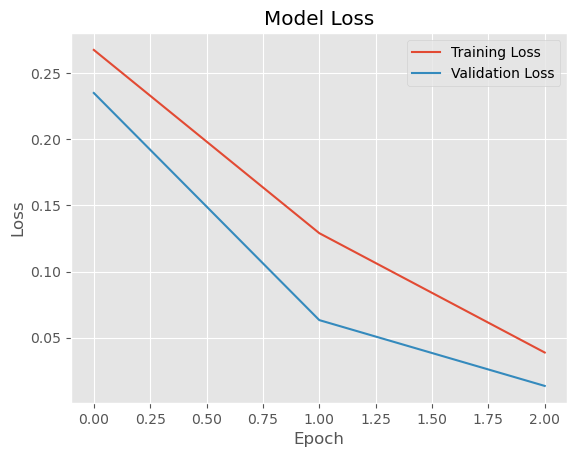

In [47]:
# Plot training loss
plt.plot(history.history['loss'])
# Plot validation loss
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig('loss_plot.png')  # Save plot as PNG file
plt.show()



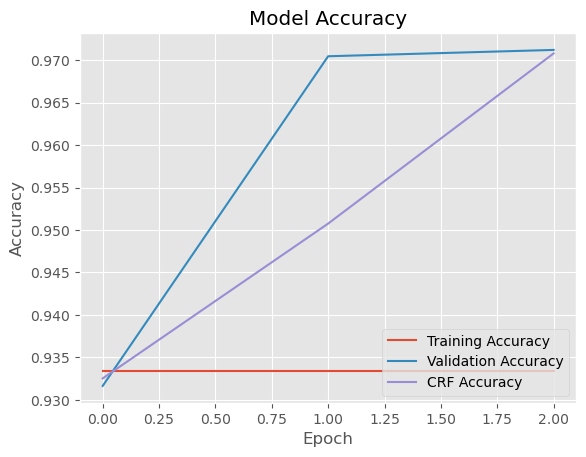

In [48]:
# Plot training accuracy
plt.plot(history.history['acc'])
# Plot validation accuracy
plt.plot(history.history['val_acc'])
plt.plot(history.history['crf_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy', 'CRF Accuracy'], loc='lower right')
plt.savefig('accuracy_plot.png')  # Save plot as PNG file
plt.show()


## Load test data

In [49]:
testdata = pd.read_csv("/kaggle/input/Jargon/test_no_labels.csv")

## Pre-process data to get sentence ids

In [50]:
testdata['prefix'] = testdata['token_id'].apply(lambda x: x.split('/')[:3])
testdata['prefix'] = testdata['prefix'].apply(lambda x: '/'.join(x))

In [51]:
test_id_dict = {}
test_id_counter = 0
for token_id in testdata['prefix']:
    if token_id not in test_id_dict:
        test_id_dict[token_id] = test_id_counter
        test_id_counter += 1

# Replace the token IDs in the data with their corresponding integer IDs
testdata["id"] = [test_id_dict[token_id] for token_id in testdata["prefix"]]

In [52]:
testdata

,token_id,token,label,prefix,id
0,cs/doc_1977/0/0,Next,O,cs/doc_1977/0,0
1,cs/doc_1977/0/1,",",O,cs/doc_1977/0,0
2,cs/doc_1977/0/2,we,O,cs/doc_1977/0,0
3,cs/doc_1977/0/3,analyze,O,cs/doc_1977/0,0
4,cs/doc_1977/0/4,the,O,cs/doc_1977/0,0
...,...,...,...,...,...
42353,phys/doc_2100/10/20,also,O,phys/doc_2100/10,1610
42354,phys/doc_2100/10/21,presented,O,phys/doc_2100/10,1610
42355,phys/doc_2100/10/22,and,O,phys/doc_2100/10,1610
42356,phys/doc_2100/10/23,discussed,O,phys/doc_2100/10,1610


In [53]:
test_df = testdata.drop(['token_id', 'prefix'], axis=1)

In [54]:
id_counts = test_df.groupby('id').count()
sent_size_df = id_counts[['token']].rename(columns={'token': 'size'})
print(f"{sent_size_df}\n\n")
total_sent_size = sent_size_df['size'].sum()
print(f"total_sent_size: {total_sent_size}")

      size
id        
0       13
1      127
2       19
3       29
4       34
...    ...
1606    17
1607    23
1608    17
1609    20
1610    25

[1611 rows x 1 columns]


total_sent_size: 42357


In [55]:
test_getter = SentenceGetter(test_df)
test_sentences = test_getter.sentences
test_largest_sen = max(len(sen) for sen in test_sentences)
print('biggest sentence has {} words'.format(test_largest_sen))

biggest sentence has 127 words


In [56]:
len(test_sentences)

1611

## Plot distribution of sentence lengths

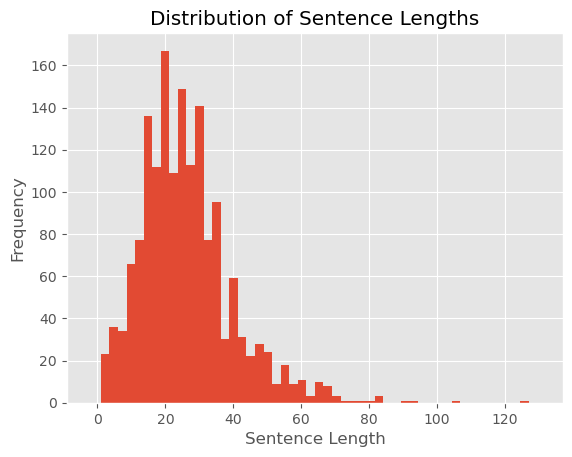

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

test_sent_lengths = [len(sen) for sen in test_sentences]
test_max_len = max(test_sent_lengths)
test_min_len = min(test_sent_lengths)

plt.hist(test_sent_lengths, bins=50)
plt.xlim([test_min_len-10, test_max_len+10])
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.savefig('DistSentLenTest.png')  # Save plot as PNG file
plt.show()

## Pad sentences to make every sentence of size max_len as defined

In [59]:
      
max_len = 25
test_sent = [[w[0] for w in s] for s in test_sentences]
X_test = []

test_padwordCount_sentwise = []

for seq_x in test_sent:
    if len(seq_x) > max_len:
        # Break sentence into temporary list of sentences of size 25 or less
        temp_seq_x = []
        while len(seq_x) > max_len:
            temp_seq_x.append(seq_x[:max_len])
            seq_x = seq_x[max_len:]
        temp_seq_x.append(seq_x)

        # Create an entry in new_X and new_y for each sentence and add corresponding padwords count
        for temp_x in temp_seq_x:
            new_seq_x = temp_x + ["PADword"] * (max_len - len(temp_x))
            X_test.append(new_seq_x)
            test_padwordCount_sentwise.append(len([word for word in new_seq_x if word == "PADword"]))

    elif len(seq_x) < max_len:
        # Pad sentence with 'PADword' to make it max_len in length
        new_seq_x = seq_x + ["PADword"] * (max_len - len(seq_x))
        X_test.append(new_seq_x)
        test_padwordCount_sentwise.append(len([word for word in new_seq_x if word == "PADword"]))

    else:
        # Sentence length is already max_len, just add and padwords count as 0
        X_test.append(seq_x)
        test_padwordCount_sentwise.append(0)
        

In [60]:
len(X_test)

2466

## Add PADword sentences to make the last batch divisible by batch_size

In [61]:
total_padwords = sum(test_padwordCount_sentwise)
total_tokens = len(X_test) * max_len
remaining_tokens = total_tokens - total_padwords
print(f"total_padwords: {total_padwords}, remaining_tokens: {remaining_tokens}")

total_padwords: 19292, remaining_tokens: 42358


In [62]:
orig_testX_len = len(X_test)
print(f"X_test shape : {len(X_test)}")

X_test shape : 2466


In [63]:
# Define the number of sentences to generate
test_num_sentences = batch_size-(len(X_test)%batch_size)
if test_num_sentences > 0:    
    # Define the length of each sentence
    sentence_length = 25
    # Generate the sentences
    test_pad_sentences = [['PADword' for _ in range(sentence_length)] for _ in range(test_num_sentences)]
    # Add the sentences to X_test
    X_test.extend(test_pad_sentences)
    


In [64]:
print(f"X_test: {len(X_test)}")

X_test: 2496


## Generate test set predictions

In [65]:
test_pred = tech_jargon_model.predict(np.array(X_test), verbose=1)

2496/2496 [==============================] - 189s 76ms/step


In [66]:
print(len(test_pred))

2496


In [67]:
idx2tag = {i: w for w, i in tags2index.items()}

In [68]:
idx2tag

{0: 'O', 1: 'TERM'}

## This function generates predictions for every valid token in every sentence 

In [69]:
def pred2label(pred, text_X):
    sentout = []
    for i in range(orig_testX_len):
        out = []
        pad_len = test_padwordCount_sentwise[i]
        sent_len = sentence_length - pad_len
        if i < 15:
            print(f"pad words for sent{i}: {pad_len}, exact sent len: {sent_len}")            
        for j in range(sent_len):
            p_i = np.argmax(pred[i][j])
            out.append(idx2tag[p_i])
        sentout.append(out)
    return sentout

In [70]:
pred_labels = pred2label(test_pred, text_X=X_test)

pad words for sent0: 12, exact sent len: 13
pad words for sent1: 0, exact sent len: 25
pad words for sent2: 0, exact sent len: 25
pad words for sent3: 0, exact sent len: 25
pad words for sent4: 0, exact sent len: 25
pad words for sent5: 0, exact sent len: 25
pad words for sent6: 23, exact sent len: 2
pad words for sent7: 6, exact sent len: 19
pad words for sent8: 0, exact sent len: 25
pad words for sent9: 21, exact sent len: 4
pad words for sent10: 0, exact sent len: 25
pad words for sent11: 16, exact sent len: 9
pad words for sent12: 0, exact sent len: 25
pad words for sent13: 8, exact sent len: 17
pad words for sent14: 5, exact sent len: 20


In [71]:
pred_labels[1]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'TERM',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [72]:
# Count the total number of elements
num_elements = sum(len(sublist) for sublist in pred_labels)

print("Number of elements: ", num_elements)


Number of elements:  42358


## Modify the result dataframe so as to match kaggle test set predictions upload configuration

In [73]:
# Flatten the list of lists
flat_list = [item for sublist in pred_labels for item in sublist]

# Create a DataFrame with a single column 'list' containing the flattened list
pred_labels_df = pd.DataFrame({'label': flat_list})
pred_labels_df.head(10)

,label
0,O
1,O
2,O
3,O
4,O
5,O
6,O
7,TERM
8,O
9,O


## Append a new column of predictions and drop useless columns 

In [74]:
testdata['label'] = pred_labels_df
# Delete the columns 'token', 'prefix', and 'id'
testdata = testdata.drop(['token', 'prefix', 'id'], axis=1)
testdata

,token_id,label
0,cs/doc_1977/0/0,O
1,cs/doc_1977/0/1,O
2,cs/doc_1977/0/2,O
3,cs/doc_1977/0/3,O
4,cs/doc_1977/0/4,O
...,...,...
42353,phys/doc_2100/10/20,O
42354,phys/doc_2100/10/21,O
42355,phys/doc_2100/10/22,O
42356,phys/doc_2100/10/23,O


# write predictions to csv file for unknown test set prediction in kaggle

In [75]:
testdata.to_csv('bilstm_crf_output_predictions.csv', index=False) 

## Upload the predictions to kaggle challenge here https://www.kaggle.com/competitions/jargon-detection/submissions